<br />

<div style="text-align: left;">
<font size="7">Car Fuel Consumption</font>
</div>
<br />
<div style="text-align: right;">
<font size="4">Minoru katsuta ml_tokyo_9 2018-2019</font>
</div>

<br />

## 課題設定　100kmあたりのガソリン消費量を予測

#### ＜Context＞
- どんな要素がガソリンを消費するのかを予測してほしい
- SP98,E10のガソリンの種類に応じて消費量を予測してほしい

- 線形回帰モデルを試行したところ、E10では0.4リットル以上消費していた
- 線形回帰モデルは特徴量が独立している場合にしか使用できない欠点があることに留意

#### ＜Content＞
- このデータには、以下のデータが含まれている
- distance:車のディスプレイに表示される距離（km）
- consume:消費量（L/100km）
- speed:平均速度（km/h）
- temp_inside:内部温度(℃)
- temp_outside:外部温度（℃）
- specials:乗車中に以下の３つの特別なことがあった場合
- AC:エアコンをつけていた
- rain:雨が降っていた場合
- sun:天候が晴れで車のエンジンをスタートする際に温かく感じたとき
- gas_type:E10,SP98の2種類のいずれかを使用
- refill liters:どのくらいガソリンを給油したのか
- refill gas:どの種類のガソリンを給油したのか

### 1．データセットの読み込みとデータ内容の確認

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
import seaborn as sns

from sklearn.model_selection import train_test_split # ホールドアウト法の関数
from sklearn.model_selection import KFold # 交差検証法の関数
# 回帰問題におけるＭＡＥ（平均絶対値誤差）,ＭＳＥ（平均２乗和誤差）を算出する関数
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [2]:
df_ms1 = pd.read_csv("../1_data/measurements.csv") #CSVFileを読み込む pandasの関数}
display(df_ms1.head()) #datasetの先頭5行を表示
df_ms1.describe(include = 'all')

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
count,388,388,388.000000,376,388.000000,93,388,388.000000,388.000000,388.000000,13,13
unique,174,43,NaN,13,NaN,12,2,NaN,NaN,NaN,10,2
top,"11,8","4,5",NaN,"21,5",NaN,rain,SP98,NaN,NaN,NaN,39,SP98
freq,37,27,NaN,133,NaN,32,228,NaN,NaN,NaN,2,8
mean,NaN,NaN,41.927835,NaN,11.358247,NaN,NaN,0.077320,0.123711,0.082474,NaN,NaN
std,NaN,NaN,13.598524,NaN,6.991542,NaN,NaN,0.267443,0.329677,0.275441,NaN,NaN
min,NaN,NaN,14.000000,NaN,-5.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,32.750000,NaN,7.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,40.500000,NaN,10.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,50.000000,NaN,16.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN


In [3]:
df_ms1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null object
consume          388 non-null object
speed            388 non-null int64
temp_inside      376 non-null object
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill liters    13 non-null object
refill gas       13 non-null object
dtypes: int64(5), object(7)
memory usage: 36.5+ KB


### 2．前処理
（１）データクレンジング

* 欠損値を含めデータを削除する。 temp_inside
* 量的変数であるべきデータの小数点がカンマとなっているため、データ補正を行う
* ガスタイプのエンコーディング

In [4]:
# temp_inside 欠損値を含むデータを削除する
df_ms1 = df_ms1.dropna(subset=['temp_inside'])

In [5]:
# distance カンマを小数点に補正
df_ms1['distance'] = df_ms1['distance'].apply(lambda x: x.replace(",", "."))
df_ms1['distance'] = df_ms1['distance'].astype(np.float)

In [6]:
# consume カンマを小数点に補正
df_ms1['consume'] = df_ms1['consume'].apply(lambda x: x.replace(",", "."))
df_ms1['consume'] = df_ms1['consume'].astype(np.float)

In [7]:
# temp_inside カンマを小数点に補正
df_ms1['temp_inside'] = df_ms1['temp_inside'].apply(lambda x: x.replace(",", "."))
df_ms1['temp_inside'] = df_ms1['temp_inside'].astype(np.float)


In [8]:
# gas_typeのエンコーディング
df_ms1.loc[df_ms1['gas_type'] == 'E10', 'gas_type']  = 0
df_ms1.loc[df_ms1['gas_type'] == 'SP98', 'gas_type'] = 1 

In [9]:
display(df_ms1.head()) #datasetの先頭5行を表示
df_ms1.describe(include = 'all')

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,0,0,0,0,45,E10
1,12.0,4.2,30,21.5,13,NaN,0,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,0,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,0,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,0,0,0,0,NaN,NaN


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
count,376.000000,376.000000,376.000000,376.000000,376.000000,91,376.000000,376.000000,376.00000,376.000000,13,13
unique,NaN,NaN,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,10,2
top,NaN,NaN,NaN,NaN,NaN,rain,NaN,NaN,NaN,NaN,39,SP98
freq,NaN,NaN,NaN,NaN,NaN,31,NaN,NaN,NaN,NaN,2,8
mean,19.797340,4.925266,41.957447,21.929521,11.340426,NaN,0.582447,0.079787,0.12500,0.082447,NaN,NaN
std,22.988878,1.040705,13.714354,1.010455,7.066999,NaN,0.493813,0.271325,0.33116,0.275411,NaN,NaN
min,1.300000,3.300000,14.000000,19.000000,-5.000000,NaN,0.000000,0.000000,0.00000,0.000000,NaN,NaN
25%,11.800000,4.300000,32.000000,21.500000,6.000000,NaN,0.000000,0.000000,0.00000,0.000000,NaN,NaN
50%,14.600000,4.700000,40.500000,22.000000,10.000000,NaN,1.000000,0.000000,0.00000,0.000000,NaN,NaN
75%,19.000000,5.300000,50.000000,22.500000,16.000000,NaN,1.000000,0.000000,0.00000,0.000000,NaN,NaN


In [10]:
df_ms1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376 entries, 0 to 387
Data columns (total 12 columns):
distance         376 non-null float64
consume          376 non-null float64
speed            376 non-null int64
temp_inside      376 non-null float64
temp_outside     376 non-null int64
specials         91 non-null object
gas_type         376 non-null int64
AC               376 non-null int64
rain             376 non-null int64
sun              376 non-null int64
refill liters    13 non-null object
refill gas       13 non-null object
dtypes: float64(3), int64(6), object(3)
memory usage: 38.2+ KB


### ２．前処理

（２）データ前処理  
 > 標準化・無相関化・白色化等を検討する

In [11]:
# 標準化のために特定のカラムを抽出してデータフレームに格納する
df_ms1_std = df_ms1[["consume", "distance", "speed", "temp_inside", "temp_outside", "gas_type", "AC", "rain","sun"]]

C:\Users\d0054302\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\d0054302\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\d0054302\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

標準化の結果


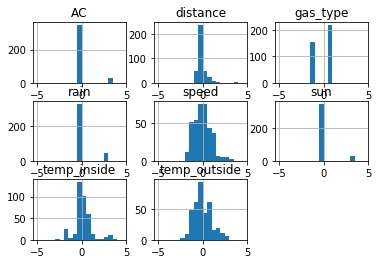

In [12]:
# 標準化を行う
df_ms1_std["distance"] = (df_ms1_std["distance"] - df_ms1_std["distance"].mean()) / df_ms1_std["distance"].std(ddof=0)
df_ms1_std["speed"]    = (df_ms1_std["speed"] - df_ms1_std["speed"].mean()) / df_ms1_std["speed"].std(ddof=0)
df_ms1_std["temp_inside"] = (df_ms1_std["temp_inside"] - df_ms1_std["temp_inside"].mean()) / df_ms1_std["temp_inside"].std(ddof=0)
df_ms1_std["temp_outside"] = (df_ms1_std["temp_outside"] - df_ms1_std["temp_outside"].mean()) / df_ms1_std["temp_outside"].std(ddof=0)
df_ms1_std["gas_type"] = (df_ms1_std["gas_type"] - df_ms1_std["gas_type"].mean()) / df_ms1_std["gas_type"].std(ddof=0)    
df_ms1_std["AC"]       = (df_ms1_std["AC"] - df_ms1_std["AC"].mean()) / df_ms1_std["AC"].std(ddof=0)
df_ms1_std["rain"]     = (df_ms1_std["rain"] - df_ms1_std["rain"].mean()) / df_ms1_std["rain"].std(ddof=0)
df_ms1_std["sun"]      = (df_ms1_std["sun"] - df_ms1_std["sun"].mean()) / df_ms1_std["sun"].std(ddof=0)

df_ms1_std.head()

#標準化の結果
df_ms1_std.iloc[:,1:].hist(bins=np.arange(-5,5,0.5))
print("標準化の結果")
plt.show()

### 今回のターゲット変数であるConsumeと説明変数の関係を確認する  

#### 目的
> １．無相関化の必要有無の確認  
> ２．説明変数の絞り込み

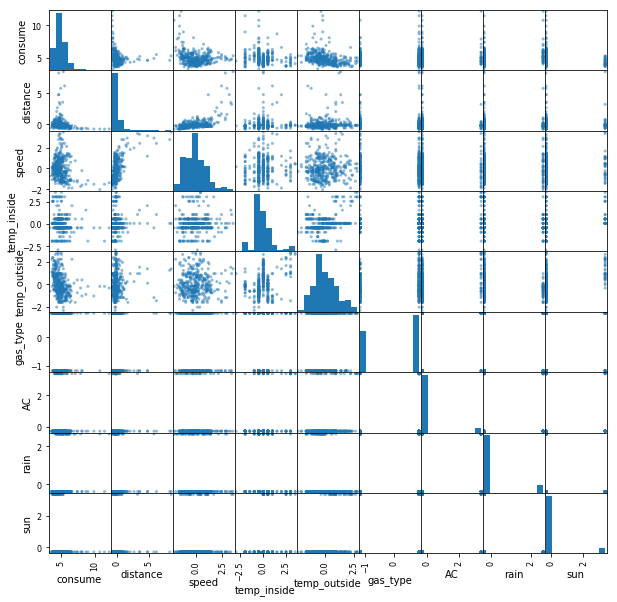

In [13]:
# pandasuを利用して散布図行列を作成する
pd.plotting.scatter_matrix(df_ms1_std, figsize=(10,10))
plt.show()

In [14]:
#ピアソンの積率相関係数を計算
df_ms1_std.corr() 

,consume,distance,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
consume,1.000000,-0.131379,-0.234537,-0.161991,-0.318758,-0.020928,0.093892,0.247699,-0.169173
distance,-0.131379,1.000000,0.565505,0.075305,0.086774,-0.047877,-0.027670,-0.022129,0.078627
speed,-0.234537,0.565505,1.000000,0.059725,0.019327,-0.099495,-0.036351,-0.002936,0.077181
temp_inside,-0.161991,0.075305,0.059725,1.000000,0.361308,0.010340,0.297775,-0.037356,0.246120
temp_outside,-0.318758,0.086774,0.019327,0.361308,1.000000,0.156990,0.169374,-0.185731,0.349988
gas_type,-0.020928,-0.047877,-0.099495,0.010340,0.156990,1.000000,0.109996,0.059112,0.038120
AC,0.093892,-0.027670,-0.036351,0.297775,0.169374,0.109996,1.000000,0.244848,0.090164
rain,0.247699,-0.022129,-0.002936,-0.037356,-0.185731,0.059112,0.244848,1.000000,-0.113298
sun,-0.169173,0.078627,0.077181,0.246120,0.349988,0.038120,0.090164,-0.113298,1.000000


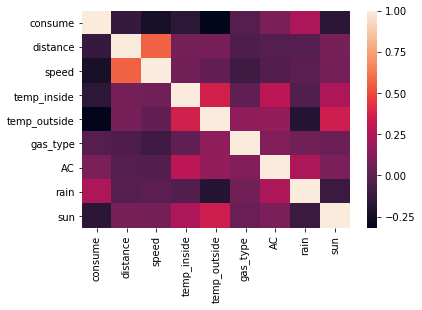

In [15]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_ms1_std.corr())
plt.show()

## ３．特徴量の選択  

### ステップワイズによる特徴量選択

In [16]:
from sklearn.feature_selection import RFECV
# estimatorにモデルをセット
# 今回は回帰問題であるためLinearRegressionを使用
estimator = LinearRegression(normalize=True)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(estimator, cv=10, scoring='neg_mean_absolute_error')


In [17]:
train_label = df_ms1_std["consume"]
train_data = df_ms1_std.drop("consume", axis=1)

y = train_label.values
X = train_data.values

# fitで特徴選択を実行
rfecv.fit(X, y)
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[4 1 3 1 6 2 1 5]


#### 上記の結果、「distance」、「temp_inside」、「gas_type」、「ac」、「sun」は特徴量から除外してみる

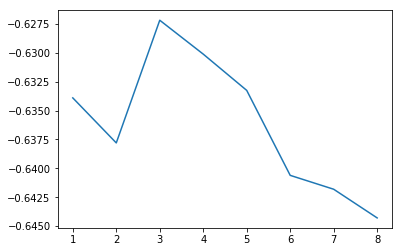

In [18]:
# 特徴数とスコアの変化をプロット
# 負のMAEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [19]:
# rfecv.support_でランキング1位以外はFalseとするindexを取得できる
# Trueになっている特徴を使用すれば汎化誤差は最小となる
rfecv.support_

array([False,  True, False,  True, False, False,  True, False])

In [20]:
# bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
# ここでTrueになっている特徴が削除してもよい特徴
remove_idx = ~rfecv.support_
remove_idx

array([ True, False,  True, False,  True,  True, False,  True])

In [21]:
# 削除してもよい特徴の名前を取得する
remove_feature = train_data.columns[remove_idx]
remove_feature

Index(['distance', 'temp_inside', 'gas_type', 'AC', 'sun'], dtype='object')

In [22]:
# drop関数で特徴を削除
selected_train_data = train_data.drop(remove_feature, axis=1)
selected_train_data

,speed,temp_outside,rain
0,-1.165108,0.093456,-0.377964
1,-0.873055,0.235147,-0.377964
2,-0.288947,0.518530,-0.377964
3,-0.434974,0.376839,-0.377964
4,0.295161,0.518530,-0.377964
5,0.587215,-0.189927,-0.377964
6,0.076120,-0.048235,-0.377964
7,-0.142920,-0.756692,-0.377964
8,-1.165108,-1.040075,-0.377964
9,-0.873055,-0.331618,-0.377964


In [23]:
def predict(cross_model):

    # ターゲット変数、説明変数を決定する
    y = train_label.values

    X = selected_train_data.values
    
    # 何分割でクロスバリデーションを実施するかグループ数を定義する
    n_split = 10
    
    # 回帰問題の評価指標の初期化 MAE（平均絶対値誤差）、MSE（平均２乗和誤差）、RMSE（平方根平均２乗和誤差）
    cross_valid_mae  = 0
    cross_valid_mse  = 0
    cross_valid_rmse = 0
    
    split_num = 1
    
    # テスト役を交代させながら学習と評価を繰り返す
    #scikitlearnのクラス『KFold』を利用して交差検証を行う
    for train_idx, test_idx in KFold(n_splits = n_split, random_state = 1234).split(X, y):
        X_train, y_train = X[train_idx], y[train_idx] #学習用データ
        X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
        
        # 学習用データを使って線形回帰モデルを学習
        #regr = LinearRegression(fit_intercept=False)
        cross_model.fit(X_train, y_train)

        # 重みを取り出す
        w0 = cross_model.intercept_
        w1 = cross_model.coef_[0]
        w2 = cross_model.coef_[1]
        w3 = cross_model.coef_[2]
#         w4 = cross_model.coef_[3]
#         w5 = cross_model.coef_[4]
#         w6 = cross_model.coef_[5]
#         w7 = cross_model.coef_[6]
#         w8 = cross_model.coef_[7]
        
#         print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8))
        print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}'.format(w0, w1, w2, w3))

        # テストデータに対する予測を実行
        y_pred_test = cross_model.predict(X_test)
    
        # テストデータに対するMAEを計算
        mae  = mean_absolute_error(y_test, y_pred_test)  #平均絶対誤差 MAE
        mse  = mean_squared_error(y_test, y_pred_test)   #平均２乗和誤差 MSE
        rmse = rmse = np.sqrt(mse)                       #平方根２乗和誤差 RMSE
        
        #print("Fold %s"%split_num)
        #print("MAE = %s"%round(mae, 3))
        #print("MSE = %s"%round(mse, 3))
        #print("RMSE = %s"%round(rmse, 3))
            
        cross_valid_mae  += mae  #後で平均を取るためにMAEを加算
        cross_valid_mse  += mse  #後で平均を取るためにMSEを加算
        cross_valid_rmse += rmse #後で平均を取るためにRMSEを加算
        split_num += 1

    # 各平均値を最終的な汎化誤差値とする
    final_mae  = cross_valid_mae  / n_split
    final_mse  = cross_valid_mse  / n_split
    final_rmse = cross_valid_rmse / n_split
    print("Cross Validation MAE  = %s"%round(final_mae, 3))
    print("Cross Validation MSE  = %s"%round(final_mse, 3))
    print("Cross Validation RMSE = %s"%round(final_rmse, 3))
    print()

    return


In [24]:
# 線形回帰モデルでクロスバリデーションを実施する

predict(LinearRegression(fit_intercept=False)) 


w0 = 0.000, w1 = -0.108, w2 = 0.131, w3 = 0.492
w0 = 0.000, w1 = -0.068, w2 = 0.002, w3 = 0.110
w0 = 0.000, w1 = -0.213, w2 = -0.010, w3 = 0.018
w0 = 0.000, w1 = -0.288, w2 = -0.015, w3 = -0.180
w0 = 0.000, w1 = -0.731, w2 = 0.194, w3 = 0.381
w0 = 0.000, w1 = -0.040, w2 = -0.179, w3 = 0.277
w0 = 0.000, w1 = -0.207, w2 = -0.363, w3 = 0.172
w0 = 0.000, w1 = -0.167, w2 = -0.570, w3 = 0.267
w0 = 0.000, w1 = -0.507, w2 = -0.961, w3 = 0.172
w0 = 0.000, w1 = -0.094, w2 = -1.452, w3 = 0.239
Cross Validation MAE  = 5.437
Cross Validation MSE  = 30.998
Cross Validation RMSE = 5.541



In [25]:
# リッジ回帰モデルでクロスバリデーションを実施する
alphas = [1.0, 1e-80, 1e-5, 1e-1]#alpha(数式ではλ)の値を4つ指定する
for alpha in alphas:
    print(alpha)
    predict(Ridge(alpha=alpha))
    print()


1.0
w0 = 4.905, w1 = -0.245, w2 = -0.273, w3 = 0.213
w0 = 4.898, w1 = -0.196, w2 = -0.286, w3 = 0.152
w0 = 4.918, w1 = -0.242, w2 = -0.279, w3 = 0.219
w0 = 4.935, w1 = -0.221, w2 = -0.304, w3 = 0.205
w0 = 4.917, w1 = -0.260, w2 = -0.285, w3 = 0.201
w0 = 4.911, w1 = -0.203, w2 = -0.284, w3 = 0.223
w0 = 4.923, w1 = -0.243, w2 = -0.303, w3 = 0.200
w0 = 4.967, w1 = -0.247, w2 = -0.280, w3 = 0.204
w0 = 4.938, w1 = -0.281, w2 = -0.279, w3 = 0.215
w0 = 4.933, w1 = -0.232, w2 = -0.302, w3 = 0.197
Cross Validation MAE  = 0.627
Cross Validation MSE  = 0.896
Cross Validation RMSE = 0.898


1e-80
w0 = 4.905, w1 = -0.246, w2 = -0.274, w3 = 0.213
w0 = 4.898, w1 = -0.196, w2 = -0.287, w3 = 0.153
w0 = 4.918, w1 = -0.243, w2 = -0.279, w3 = 0.219
w0 = 4.935, w1 = -0.222, w2 = -0.305, w3 = 0.205
w0 = 4.917, w1 = -0.261, w2 = -0.286, w3 = 0.202
w0 = 4.911, w1 = -0.203, w2 = -0.285, w3 = 0.223
w0 = 4.923, w1 = -0.243, w2 = -0.304, w3 = 0.200
w0 = 4.967, w1 = -0.248, w2 = -0.281, w3 = 0.205
w0 = 4.938, w1 =

In [ ]:
# ラッソ回帰モデルでクロスバリデーションを実施する
alphas = [1e-20, 1e-3, 1e-2, 1e-1]#alpha(数式ではλ)の値を4つ指定する
for alpha in alphas:
    print(alpha)
    predict(Lasso(alpha=alpha,max_iter=1e7))
    print()


In [ ]:
# エラスティックネットでクロスバリデーションを実施する
alpha = 1e-4 #正則化全体の強さを決定する
l1_ratios = [0, 0.1, 0.5, 1.0] #L1正則化の強さを4つ指定する（L2正則化の強さは1 - l1_ratioで自動的に設定される）

for l1_ratio in l1_ratios:
    print(l1_ratio)
    predict(ElasticNet(alpha=alpha, l1_ratio = l1_ratio, max_iter = 1e8))
    print()


### Lassoによる特徴量選択

In [26]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

In [27]:
train_label_ls = df_ms1_std["consume"]
train_data_ls = df_ms1_std.drop("consume", axis=1)

y = train_label_ls.values
X = train_data_ls.values

# fitで特徴選択を実行
sfm.fit(X, y)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [28]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([False,  True,  True,  True, False,  True,  True,  True])

In [29]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
# train_data_ls.columns[removed_idx]
remove_feature = train_data_ls.columns[removed_idx]
remove_feature

Index(['distance', 'gas_type'], dtype='object')

In [30]:
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([0.        , 0.18956441, 0.03340567, 0.25152381, 0.        ,
       0.06404984, 0.14829347, 0.01012109])

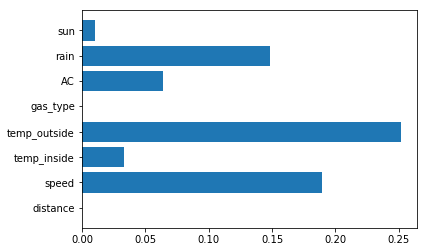

In [31]:
# 係数を棒グラフで表示
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=train_data_ls.columns.values)
plt.show()

In [32]:
selected_train_data = train_data_ls.drop(remove_feature, axis=1)
selected_train_data

,speed,temp_inside,temp_outside,AC,rain,sun
0,-1.165108,-0.425643,0.093456,-0.294457,-0.377964,-0.299758
1,-0.873055,-0.425643,0.235147,-0.294457,-0.377964,-0.299758
2,-0.288947,-0.425643,0.518530,-0.294457,-0.377964,-0.299758
3,-0.434974,-0.425643,0.376839,-0.294457,-0.377964,-0.299758
4,0.295161,-0.425643,0.518530,-0.294457,-0.377964,-0.299758
5,0.587215,-0.425643,-0.189927,-0.294457,-0.377964,-0.299758
6,0.076120,-0.425643,-0.048235,-0.294457,-0.377964,-0.299758
7,-0.142920,-0.425643,-0.756692,-0.294457,-0.377964,-0.299758
8,-1.165108,-0.425643,-1.040075,-0.294457,-0.377964,-0.299758
9,-0.873055,-0.425643,-0.331618,-0.294457,-0.377964,-0.299758


In [33]:
def predict(cross_model):

    # ターゲット変数、説明変数を決定する
    y = train_label.values

    X = selected_train_data.values
    
    # 何分割でクロスバリデーションを実施するかグループ数を定義する
    n_split = 10
    
    # 回帰問題の評価指標の初期化 MAE（平均絶対値誤差）、MSE（平均２乗和誤差）、RMSE（平方根平均２乗和誤差）
    cross_valid_mae  = 0
    cross_valid_mse  = 0
    cross_valid_rmse = 0
    
    split_num = 1
    
    # テスト役を交代させながら学習と評価を繰り返す
    #scikitlearnのクラス『KFold』を利用して交差検証を行う
    for train_idx, test_idx in KFold(n_splits = n_split, random_state = 1234).split(X, y):
        X_train, y_train = X[train_idx], y[train_idx] #学習用データ
        X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
        
        # 学習用データを使って線形回帰モデルを学習
        #regr = LinearRegression(fit_intercept=False)
        cross_model.fit(X_train, y_train)

        # 重みを取り出す
        w0 = cross_model.intercept_
        w1 = cross_model.coef_[0]
        w2 = cross_model.coef_[1]
        w3 = cross_model.coef_[2]
        w4 = cross_model.coef_[3]
        w5 = cross_model.coef_[4]
        w6 = cross_model.coef_[5]
#         w7 = cross_model.coef_[6]
#         w8 = cross_model.coef_[7]
        
        print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))
#         print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}'.format(w0, w1, w2, w3))

        # テストデータに対する予測を実行
        y_pred_test = cross_model.predict(X_test)
    
        # テストデータに対するMAEを計算
        mae  = mean_absolute_error(y_test, y_pred_test)  #平均絶対誤差 MAE
        mse  = mean_squared_error(y_test, y_pred_test)   #平均２乗和誤差 MSE
        rmse = rmse = np.sqrt(mse)                       #平方根２乗和誤差 RMSE
        
        #print("Fold %s"%split_num)
        #print("MAE = %s"%round(mae, 3))
        #print("MSE = %s"%round(mse, 3))
        #print("RMSE = %s"%round(rmse, 3))
            
        cross_valid_mae  += mae  #後で平均を取るためにMAEを加算
        cross_valid_mse  += mse  #後で平均を取るためにMSEを加算
        cross_valid_rmse += rmse #後で平均を取るためにRMSEを加算
        split_num += 1

    # 各平均値を最終的な汎化誤差値とする
    final_mae  = cross_valid_mae  / n_split
    final_mse  = cross_valid_mse  / n_split
    final_rmse = cross_valid_rmse / n_split
    print("Cross Validation MAE  = %s"%round(final_mae, 3))
    print("Cross Validation MSE  = %s"%round(final_mse, 3))
    print("Cross Validation RMSE = %s"%round(final_rmse, 3))
    print()

    return


In [34]:
# 線形回帰モデルでクロスバリデーションを実施する

predict(LinearRegression(fit_intercept=False)) 


w0 = 0.000, w1 = -0.103, w2 = 0.001, w3 = 0.101, w4 = 0.129, w5 = 0.455, w6 = 0.003
w0 = 0.000, w1 = -0.076, w2 = 0.126, w3 = -0.004, w4 = -0.162, w5 = 0.146, w6 = -0.004
w0 = 0.000, w1 = -0.242, w2 = 0.527, w3 = -0.177, w4 = -0.054, w5 = -0.001, w6 = -0.049
w0 = 0.000, w1 = -0.260, w2 = -0.251, w3 = 0.011, w4 = 0.346, w5 = -0.291, w6 = 0.002
w0 = 0.000, w1 = -0.726, w2 = -0.114, w3 = 0.201, w4 = 0.082, w5 = 0.363, w6 = 0.045
w0 = 0.000, w1 = -0.041, w2 = 0.094, w3 = -0.241, w4 = 0.065, w5 = 0.261, w6 = 0.023
w0 = 0.000, w1 = -0.148, w2 = -0.328, w3 = -0.151, w4 = 0.346, w5 = 0.057, w6 = -0.523
w0 = 0.000, w1 = -0.136, w2 = 0.010, w3 = -0.465, w4 = 0.057, w5 = 0.232, w6 = -0.446
w0 = 0.000, w1 = -0.512, w2 = -0.121, w3 = -1.098, w4 = 0.324, w5 = 0.095, w6 = 0.254
w0 = 0.000, w1 = -0.039, w2 = -1.001, w3 = -1.395, w4 = -0.255, w5 = 0.363, w6 = 0.336
Cross Validation MAE  = 5.735
Cross Validation MSE  = 35.313
Cross Validation RMSE = 5.875



In [35]:
# リッジ回帰モデルでクロスバリデーションを実施する
alphas = [1.0, 1e-80, 1e-5, 1e-1]#alpha(数式ではλ)の値を4つ指定する
for alpha in alphas:
    print(alpha)
    predict(Ridge(alpha=alpha))
    print()


1.0
w0 = 4.906, w1 = -0.233, w2 = -0.073, w3 = -0.262, w4 = 0.120, w5 = 0.179, w6 = -0.033
w0 = 4.902, w1 = -0.189, w2 = -0.059, w3 = -0.272, w4 = 0.082, w5 = 0.131, w6 = -0.037
w0 = 4.931, w1 = -0.226, w2 = -0.145, w3 = -0.247, w4 = 0.146, w5 = 0.187, w6 = -0.030
w0 = 4.929, w1 = -0.209, w2 = -0.084, w3 = -0.287, w4 = 0.134, w5 = 0.159, w6 = -0.034
w0 = 4.917, w1 = -0.248, w2 = -0.077, w3 = -0.272, w4 = 0.109, w5 = 0.171, w6 = -0.031
w0 = 4.913, w1 = -0.196, w2 = -0.007, w3 = -0.295, w4 = 0.122, w5 = 0.189, w6 = -0.044
w0 = 4.915, w1 = -0.227, w2 = -0.082, w3 = -0.293, w4 = 0.121, w5 = 0.163, w6 = -0.020
w0 = 4.968, w1 = -0.235, w2 = -0.082, w3 = -0.282, w4 = 0.152, w5 = 0.163, w6 = -0.015
w0 = 4.937, w1 = -0.268, w2 = -0.082, w3 = -0.256, w4 = 0.111, w5 = 0.183, w6 = -0.056
w0 = 4.930, w1 = -0.220, w2 = -0.078, w3 = -0.285, w4 = 0.101, w5 = 0.169, w6 = -0.039
Cross Validation MAE  = 0.632
Cross Validation MSE  = 0.9
Cross Validation RMSE = 0.901


1e-80
w0 = 4.906, w1 = -0.234, w2 = 

In [ ]:
# ラッソ回帰モデルでクロスバリデーションを実施する
alphas = [1e-20, 1e-3, 1e-2, 1e-1]#alpha(数式ではλ)の値を4つ指定する
for alpha in alphas:
    print(alpha)
    predict(Lasso(alpha=alpha,max_iter=1e7))
    print()

In [ ]:
# エラスティックネットでクロスバリデーションを実施する
alpha = 1e-4 #正則化全体の強さを決定する
l1_ratios = [0, 0.1, 0.5, 1.0] #L1正則化の強さを4つ指定する（L2正則化の強さは1 - l1_ratioで自動的に設定される）

for l1_ratio in l1_ratios:
    print(l1_ratio)
    predict(ElasticNet(alpha=alpha, l1_ratio = l1_ratio, max_iter = 1e8))
    print()


### ランダムフォレスト

MSE_train: 0.057, test: 0.473
MAE_train: 0.160, test: 0.463
RMSE_train: 0.239, test: 0.688
R^2 train: 0.948, test: 0.507
[0.38167196 0.22198515 0.07511041 0.22316266 0.03172512 0.02722185
 0.0292901  0.00983273]


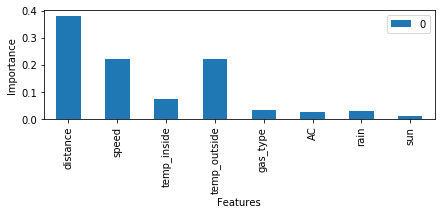

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics  import r2_score

train_label_rf = df_ms1_std["consume"]
train_data_rf = df_ms1_std.drop("consume", axis=1)

X = train_data_rf.values
y = train_label_rf.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

# forest = RandomForestRegressor(n_estimators=1000, criterion="mse", random_state=1234, n_jobs= -1)
forest = RandomForestRegressor(n_estimators=1000, criterion="mae", random_state=1234, n_jobs= -1)

forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train)
y_test_pred  = forest.predict(X_test)

print('MSE_train: %.3f, test: %.3f' %(mean_squared_error(y_train, y_train_pred),mean_squared_error(y_test, y_test_pred)))
print('MAE_train: %.3f, test: %.3f' %(mean_absolute_error(y_train, y_train_pred),mean_absolute_error(y_test, y_test_pred)))
print('RMSE_train: %.3f, test: %.3f' %(np.sqrt(mean_squared_error(y_train, y_train_pred)),np.sqrt(mean_squared_error(y_test, y_test_pred))))

print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),r2_score(y_test, y_test_pred)))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(forest.feature_importances_)
pd.DataFrame(forest.feature_importances_, index=train_data_rf.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()



### 決定木

MSE_train: 0.035, test: 1.244
MAE_train: 0.090, test: 0.617
RMSE_train: 0.187, test: 1.115
R^2 train: 0.968, test: -0.297
[0.36957779 0.26026605 0.06651243 0.21688837 0.01966455 0.03585888
 0.01792944 0.01330249]


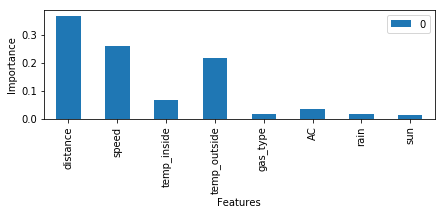

In [95]:
train_label_rf = df_ms1_std["consume"]
train_data_rf = df_ms1_std.drop("consume", axis=1)

X = train_data_rf.values
y = train_label_rf.values

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.2, random_state = 1234)

tree = DecisionTreeRegressor(criterion='mae', max_depth=10, random_state=1234)

tree.fit(X_train2, y_train2)

y_train_pred2 = tree.predict(X_train2)
y_test_pred2  = tree.predict(X_test2)

print('MSE_train: %.3f, test: %.3f' %(mean_squared_error(y_train2, y_train_pred2),mean_squared_error(y_test2, y_test_pred2)))
print('MAE_train: %.3f, test: %.3f' %(mean_absolute_error(y_train2, y_train_pred2),mean_absolute_error(y_test2, y_test_pred2)))
print('RMSE_train: %.3f, test: %.3f' %(np.sqrt(mean_squared_error(y_train2, y_train_pred2)),np.sqrt(mean_squared_error(y_test2, y_test_pred2))))

print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train2, y_train_pred2),r2_score(y_test2, y_test_pred2)))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(tree.feature_importances_)
pd.DataFrame(tree.feature_importances_, index=train_data_rf.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()



### AdaBoost

MSE_train: 0.089, test: 0.520
MAE_train: 0.244, test: 0.461
RMSE_train: 0.298, test: 0.721
R^2 train: 0.919, test: 0.458
[0.51165387 0.17905876 0.063537   0.13235947 0.0344523  0.03962095
 0.032288   0.00702964]


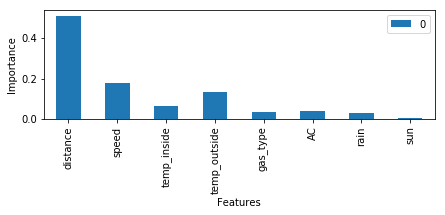

In [129]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

train_label_rf = df_ms1_std["consume"]
train_data_rf = df_ms1_std.drop("consume", axis=1)

X = train_data_rf.values
y = train_label_rf.values

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size = 0.2, random_state = 1234)


Ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5,
                                                                                 min_samples_leaf=2,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="mae"),
                                           n_estimators=1000,loss='exponential', random_state=1234)
Ada.fit(X_train3, y_train3)

y_train_pred3 = Ada.predict(X_train3)
y_test_pred3  = Ada.predict(X_test3)

print('MSE_train: %.3f, test: %.3f' %(mean_squared_error(y_train3, y_train_pred3),mean_squared_error(y_test3, y_test_pred3)))
print('MAE_train: %.3f, test: %.3f' %(mean_absolute_error(y_train3, y_train_pred3),mean_absolute_error(y_test3, y_test_pred3)))
print('RMSE_train: %.3f, test: %.3f' %(np.sqrt(mean_squared_error(y_train3, y_train_pred3)),np.sqrt(mean_squared_error(y_test3, y_test_pred3))))

print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train3, y_train_pred3),r2_score(y_test3, y_test_pred3)))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(Ada.feature_importances_)
pd.DataFrame(Ada.feature_importances_, index=train_data_rf.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

### ニューラルネットワーク

In [139]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from keras.wrappers.scikit_learn import KerasRegressor

In [140]:
train_label_rf = df_ms1_std["consume"]
train_data_rf = df_ms1_std.drop("consume", axis=1)

X = train_data_rf.values
y = train_label_rf.values

X_train4,X_test4, y_train4, y_test4 = train_test_split(X, y, test_size = 0.2, random_state = 1234)


In [212]:
def reg_model(out_dim=10, activation='relu', optimizer=Adam, hidden_cnt=10):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_dim=8))
#     model.add(Dense(5, activation='relu', input_dim=10))
    model.add(Dense(1, activation= 'relu'))#最終層のactivationは変更しないこと

#     ------ 最適化手法 ------
#     sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
#     rms = RMSprop(lr=0.01)
    # adag = Adagrad(lr=0.01)
    # adad = Adadelta(lr=0.01)
    adam = Adam(lr=0.1)
    # -----------------------------

    model.compile(loss='mean_absolute_error',optimizer=adam)
    
    return model

In [216]:
Nn = KerasRegressor(build_fn=reg_model,epochs=100,batch_size=32,verbose=0)

Nn.fit(X_train4, y_train4)


y_train_pred4 = Nn.predict(X_train4)
y_test_pred4  = Nn.predict(X_test4)


print('MSE_train: %.3f, test: %.3f' %(mean_squared_error(y_train4, y_train_pred4),mean_squared_error(y_test4, y_test_pred4)))
print('MAE_train: %.3f, test: %.3f' %(mean_absolute_error(y_train4, y_train_pred4),mean_absolute_error(y_test4, y_test_pred4)))
print('RMSE_train: %.3f, test: %.3f' %(np.sqrt(mean_squared_error(y_train4, y_train_pred4)),np.sqrt(mean_squared_error(y_test4, y_test_pred4))))

print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train4, y_train_pred4),r2_score(y_test4, y_test_pred4)))



MSE_train: 0.456, test: 0.547
MAE_train: 0.435, test: 0.584
RMSE_train: 0.675, test: 0.740
R^2 train: 0.588, test: 0.430
